# The Data

The data was downloaded from <a href="https://finance.yahoo.com/quote/%5EIXIC?p=%5EIXIC">Yahoo! Finance</a> and the inflation calculator <a href="https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/">The US Inflation Calculator</a>.

The index data are stored in:
- S&P 500 - `Data/snp500.csv`,
- DOW Jones Industrial Average - `Data/dow.csv`,
- NASDAQ Composite - `Data/nasdaq_composite.csv`.

The consuper price index data is stored in `Data/cpi.csv`.

In [1]:
## The following packages are used
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from seaborn import set_style

set_style("whitegrid")

In [2]:
snp = pd.read_csv("Data/snp500.csv",
                     parse_dates = ['date'])

nasdaq = pd.read_csv("Data/nasdaq_composite.csv",
                     parse_dates = ['date'])

dow = pd.read_csv("Data/dow.csv",
                     parse_dates = ['date'])

cpi = pd.read_csv("data/cpi.csv",
                     parse_dates = ['date'])

### Example: Plotting S&P 500

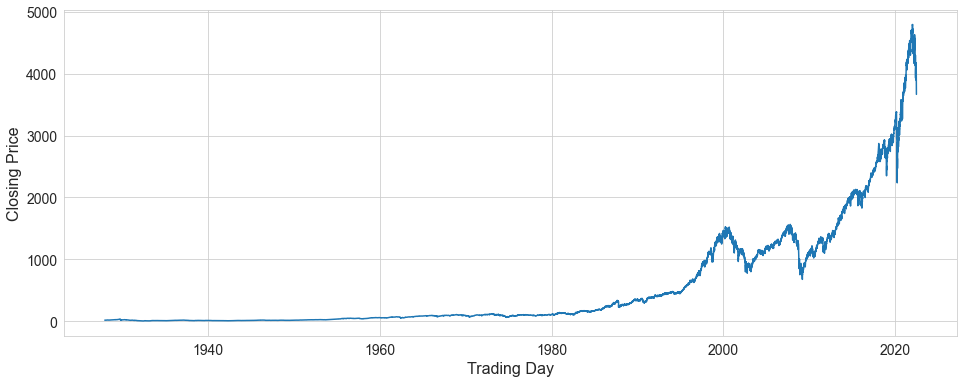

In [11]:
plt.figure(figsize=(16,6))

plt.plot(snp.date, snp.close)

plt.xlabel("Trading Day", fontsize=16)
plt.ylabel("Closing Price", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## Calculating Index Multipliers

Here is the code I used to calculate the index multipliers.

In [4]:
## get_price(df, date, years)
## this will get the closing price on the trading day
## closest to the given date years years into the future.
## The given df should be the historical data on the index
def get_price(df, date, years):
    # find_date is the date years years into the future
    find_date = date + relativedelta(years=years)
    
    # the longest the NY stock exchange was ever not trading
    # was two weeks for the given index data
    for i in range(15):
        # check if the date is one of the trading days
        if find_date + timedelta(days = i) in df.date.values:
            # if so return the closing price on that day
            return df.loc[df.date == find_date + timedelta(days = i)].close.values[0]

## get_date(df, date, years)
## This function returns the trading day closest
## to the given date years years into the future
def get_date(df, date, years):
    # the date we want to compare to
    find_date = date + relativedelta(years=years)
    
    # the longest the NY stock exchange was ever not trading
    # was two weeks for the given indices
    for i in range(15):
        # check if the date is one of the trading days
        if find_date + timedelta(days = i) in df.date.values:
            # if so return the closing price on that day
            return find_date
        
## find_last_date(df, years)
## This function returns the last possible trading day
## we can consider that has a trading day years years in the future.
## for example, if our data ended on June 2, 2022 and years = 30
## find_last_date would return June 2, 1992
def find_last_date(df, years):
    # take the last trading day and subtract years years
    last_possible_date = df.date.max() - relativedelta(years=years)
    
    # if the df has trading days before the given last_possible_date
    if len(df.loc[df.date <= last_possible_date]) > 0:
        # record the index of the trading day closest but not after to
        # last_possible_date
        i = df.loc[df.date <= last_possible_date].index[0]
    else:
        # otherwise return -99
        i = -99
    
    return i

### Example: Calculating the 30 year multipliers for the S&P 500

In [12]:
snp_rois = []

for i in range(len(snp)-1, find_last_date(snp, 30), -1):
    snp_rois.append(get_price(snp, snp.date[i], 30)/(snp.close[i]))

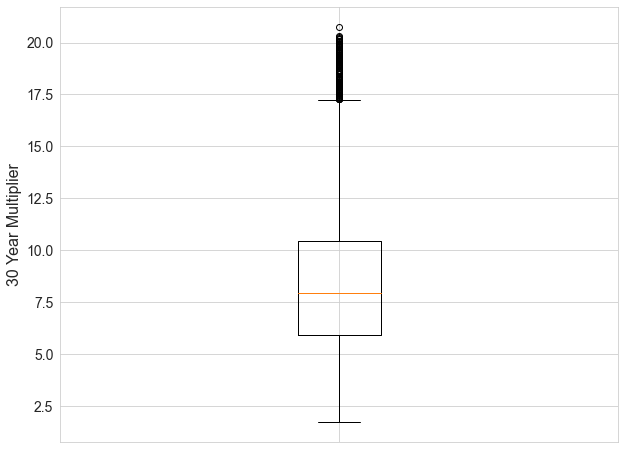

In [18]:
plt.figure(figsize=(10,8))

plt.boxplot(snp_rois)

plt.xticks([1], [])
plt.yticks(fontsize=14)

plt.ylabel("30 Year Multiplier", fontsize=16)

plt.show()

## Calculating Inflation Multipliers

This function was used to calculate the inflation multipliers. This is derived from the US Inflation Calculator formula, <a href="https://www.usinflationcalculator.com/frequently-asked-questions-faqs/#HowInflationCalculatorWorks">https://www.usinflationcalculator.com/frequently-asked-questions-faqs/#HowInflationCalculatorWorks</a>.

In [5]:
## get_inflation(cpi, i, years)
## This calculates the inflation multiplier from a given
## index for an elapsed time of years years
def get_inflation(cpi, i, years):
    return cpi.loc[i+years*12,'cpi']/cpi.loc[i,'cpi']

### Example: 30 Year Inflation Multipliers

In [17]:
inflations = []

for i in range(len(cpi)-12*30):
    inflations.append(get_inflation(cpi, i, 30))

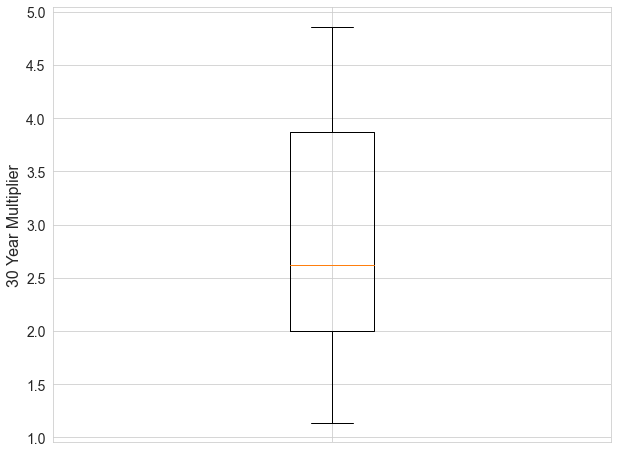

In [20]:
plt.figure(figsize=(10,8))

plt.boxplot(inflations)

plt.xticks([1], [])
plt.yticks(fontsize=14)

plt.ylabel("30 Year Multiplier", fontsize=16)

plt.show()

## Getting investment plan multipliers

This code was used to calculate the multipliers used in the user input investment calculator portion of the post.

In [6]:
## For a given stock index and max_yrs investment timeline
## return the last possible trading day we can consider
def get_last_possible_date(stock, max_yrs):
    return pd.to_datetime(stock.loc[stock.date <= stock.date.max() - relativedelta(years=max_yrs)].date.max())


## This function returns every yearly multiplier for a given
## stock index, investment start_date and max_yrs investment timeline
## For example if start_date = June 2, 1992 and max_yrs = 30
## This would record the multipliers for investments ending on 
## June 2, 2022 and starting on June 2, 1992, June 2, 1993, June 2, 1994, etc.
def get_mults(stock, start_date, max_yrs):
    # make an empty array to fill
    mults = np.zeros(max_yrs)
    
    # get the closing price on the withdrawl date
    max_price = stock.loc[stock.date >= start_date + relativedelta(years=max_yrs)].close.values[-1]
        
    # for each year less than our withdrawl time   
    for i in range(max_yrs):
        # get the starting price for the investment date
        init_price = stock.loc[stock.date >= start_date + relativedelta(years=i)].close.values[-1]
        
        # calculate and record the multiplier
        mults[i] = max_price/init_price
        
    return mults

### Example

In [22]:
get_mults(snp, snp.date[20000], 30)

array([12.60920771, 10.48708816,  9.12238575,  6.75286697,  8.12767426,
        7.87759197,  7.7838731 ,  7.17672151,  6.19842105,  5.11820947,
        4.5807079 ,  4.71645975,  3.41461293,  2.57702407,  2.56133101,
        2.84674885,  2.24195698,  2.00527839,  2.12927138,  1.6354673 ,
        1.90135615,  1.59970117,  1.3990259 ,  1.29034732,  1.46772183,
        1.23838065,  1.09026106,  1.28499727,  1.32474691,  1.21337317])

That is all the python code I used to calculate the data for the post.